<u><b>This notebook contains tools to train the UNet model, but also gridsearch for the best postprocessing parameter. Everything can be loaded from preexisting saves to rapidly output a prediction. </u></b>

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os, sys, re
from PIL import Image

import pandas as pd

import torch
from torch.utils.data import DataLoader

from preprocessing import *
from experimental_neural_nets import Road_data, UNet
from road_correction import process_roads, f1_loss_numpy
from mask_to_submission import masks_to_submission

In [23]:
# Global params for UNet and Road Correction (SEARCH or LOAD, option to SAVE if SEARCH)
UNET_SEARCH = False
SAVE_UNET = False
UNET_TRAIN = False
ROAD_CORRECTION_SEARCH = False
SAVE_RC_PARAMS = False
THRESHOLD_SEARCH = False
UNET_MODEL_LOAD = 'UNet_model_16_7_opti.pth'
UNET_MODEL_SAVE = 'UNet_model_new.pth'
RC_LOAD = 'RC_params_opti.pth'
RC_SAVE = 'RC_params_new.pth'

# Input final prediction name
submission_filename = 'final_pred.csv'

### <b> Train images and groundtruth loading </b>

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [4]:
root_dir = "data/training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files))  # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])

if UNET_SEARCH or UNET_TRAIN:
    imgs,gt_imgs = rotate_train_data(imgs,gt_imgs)
    imgs,gt_imgs = flip_train_data(imgs,gt_imgs)

Loading 100 images
satImage_001.png
Loading 100 images
satImage_001.png


### <b>Search for best number of layers/bases in a limited range of epoch or loading of presaved/pretrained model</b>

In [ ]:
if UNET_SEARCH:

    # Modulate search
    num_epochs = 10
    batch_size = 10
    bases = [16]
    layers = [7]

    dataset = Road_data(imgs,gt_imgs)

    best_loss = np.inf
    best_base = 0
    best_n_layer = 0


    for base_c in bases:
        for n_layer in layers:

            model = UNet(base_c=base_c,num_layers=n_layer)
            losses = []
            criterion = torch.nn.BCEWithLogitsLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
            dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

            for epoch in range(num_epochs):
                for batch_idx, (data, target) in enumerate(dataloader):

                    optimizer.zero_grad()
                    output = model(data)
                    loss = criterion(output, target)
                    loss.backward()
                    optimizer.step()

                losses.append(loss)
                scheduler.step()
                print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
                
            c_loss = min(losses)
            if c_loss < best_loss:
                best_base = base_c
                best_n_layer = n_layer
                best_loss = c_loss
    print (f'best c_base: {best_base} \nbest number of layers: {best_n_layer}')
    model = UNet(base_c=best_base,num_layers=best_n_layer)

else:
    model = torch.load(UNET_MODEL_LOAD)

C:\Users\edgar\AppData\Local\Temp\ipykernel_18000\2467003361.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(UNET_MODEL_LOAD)


### <b> Model deep training </b>

In [6]:
if UNET_TRAIN:

    # Modulate training
    num_epochs = 40
    batch_size = 10

    dataset = Road_data(imgs,gt_imgs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

    for epoch in range(num_epochs):
        for batch_idx, (data, target) in enumerate(dataloader):

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

        scheduler.step()
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}")
    
    # optional save
    if SAVE_UNET:
        torch.save(model, UNET_MODEL_SAVE)

model.eval();

### <b>Optional threshold search minimizing f1 loss </b>

In [8]:
dataset = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset, batch_size=5, shuffle=True)

best_threshold = 0.1

if THRESHOLD_SEARCH:
    thresholds = np.linspace(0.10,0.60,20)
    c_losses = []
    best_loss = np.inf

    for threshold in thresholds:
        for batch_idx, (data, target) in enumerate(dataloader):

            gt = target
            images = data
            pred = model(data)
            gt_np = gt.detach().cpu().numpy()
            pred_np = pred.detach().cpu().numpy()
            binary_pred = (pred_np > threshold).astype(np.uint8)
            c_losses.append(np.mean([f1_loss_numpy(p, truth) for p, truth in zip(binary_pred,gt_np)]))
                
        c_loss = np.mean(c_losses)
        if c_loss < best_loss:
            best_loss = c_loss
            best_threshold = threshold
            print(f'current best loss: {best_loss}')
            print(f'current best threshold: {best_threshold}')
    

### <b> GridSearch over best hyperparams for road postprocessing </b>

In [ ]:
if ROAD_CORRECTION_SEARCH:

    # Modulate search
    outlier_sizes = [1]
    shape_sizes = [1]
    max_connection_distances = np.arange(40,101,5)

    threshold = best_threshold
    best_outlier_size = 0
    best_shape_size = 0
    best_mcd = 1
    best_loss = np.inf

    for outlier_size in outlier_sizes:
        for shape_size in shape_sizes:
            for max_connection_distance in max_connection_distances:

                print(f'outlier size : {outlier_size} | shape size : {shape_size} | max connection distance : {max_connection_distance}')
                c_losses = []
                
                for batch_idx, (data, target) in enumerate(dataloader):

                    gt = target
                    images = data
                    pred = model(data)

                    gt_np = gt.detach().cpu().numpy()
                    pred_np = pred.detach().cpu().numpy()
                    test_pred = np.array([
                        process_roads(raw_map=raw_map, threshold=threshold, outlier_size=outlier_size, shape_size=shape_size, max_connection_distance=max_connection_distance, connect=True)[0] 
                        for raw_map in pred_np
                        ])
                    
                    c_losses.extend([f1_loss_numpy(p, truth) for p, truth in zip(test_pred,gt_np)])
                
                c_loss = np.mean(c_losses)
                if c_loss < best_loss:
                    best_loss = c_loss
                    print(f'best loss = {best_loss}')
                    best_outlier_size = outlier_size
                    best_shape_size = shape_size
                    best_mcd = max_connection_distance

    # optional save
    if SAVE_RC_PARAMS:
        best_params = {'best_outlier_size':best_outlier_size,'best_shape_size':best_shape_size, 'max_connection_distance':max_connection_distance}
        torch.save(best_params, RC_SAVE)

else:
    best_params = torch.load(RC_LOAD)
    best_outlier_size = best_params['best_outlier_size']
    best_shape_size = best_params['best_shape_size']
    best_mcd = best_params['max_connection_distance']


outlier size : 1 | shape size : 1 | max connection distance : 40


c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:216: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  filled_map = closing(cleaned_mask, square(shape_size))
c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:36: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated_skeleton = binary_dilation(skeleton, footprint=square(width))
c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:142: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated_region = binary_dilation(current_connection, footprint=square(road_width))


best loss = 0.11096814617652324
outlier size : 1 | shape size : 1 | max connection distance : 45
outlier size : 1 | shape size : 1 | max connection distance : 50
best loss = 0.11087010198065755
outlier size : 1 | shape size : 1 | max connection distance : 55
best loss = 0.11065469942643963
outlier size : 1 | shape size : 1 | max connection distance : 60
best loss = 0.11050701286349572
outlier size : 1 | shape size : 1 | max connection distance : 65
outlier size : 1 | shape size : 1 | max connection distance : 70
outlier size : 1 | shape size : 1 | max connection distance : 75
outlier size : 1 | shape size : 1 | max connection distance : 80
outlier size : 1 | shape size : 1 | max connection distance : 85
outlier size : 1 | shape size : 1 | max connection distance : 90
outlier size : 1 | shape size : 1 | max connection distance : 95
outlier size : 1 | shape size : 1 | max connection distance : 100


### <b> Plot examples of predicted and postprocessed binary maps from train set</b>

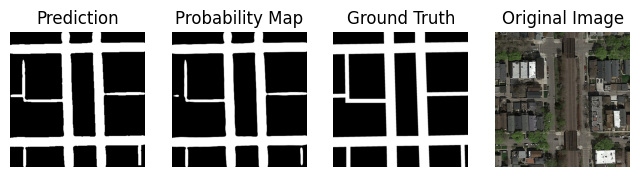

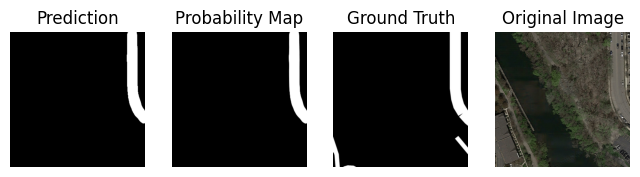

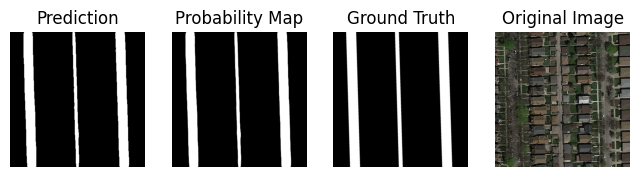

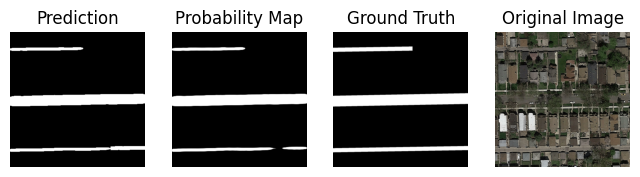

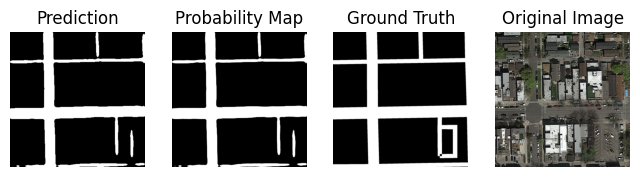

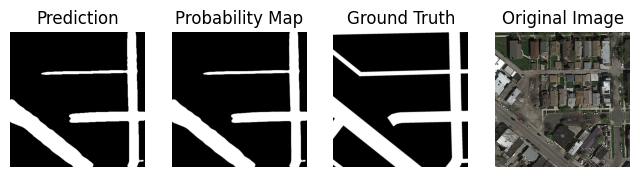

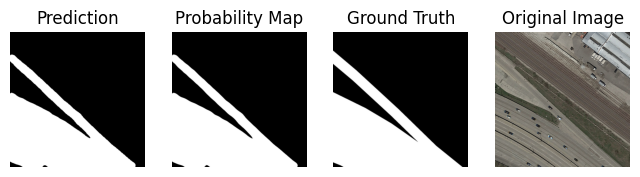

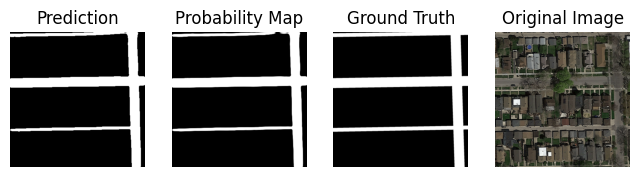

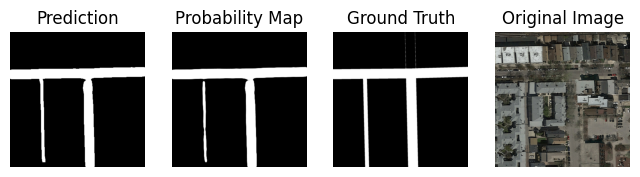

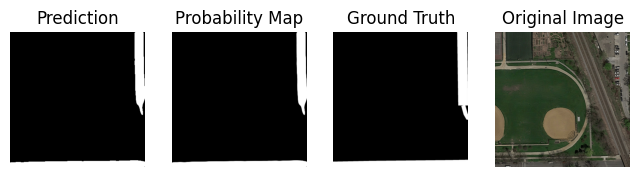

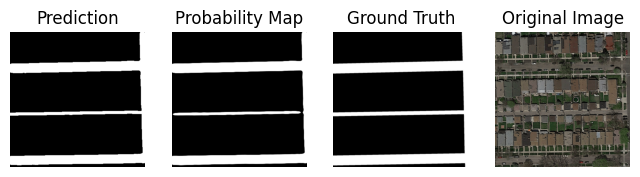

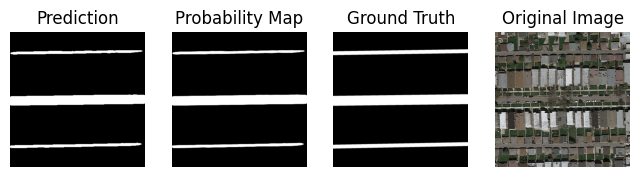

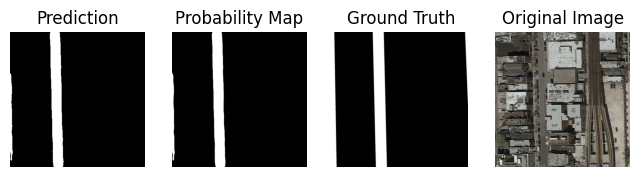

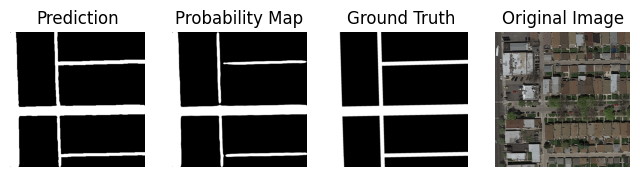

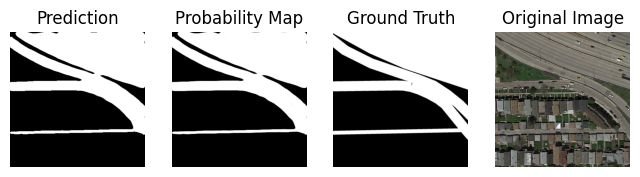

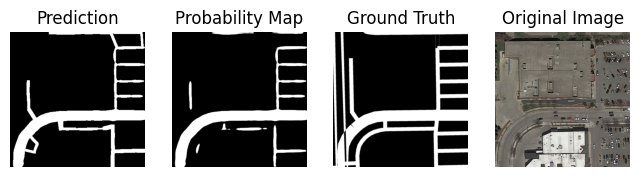

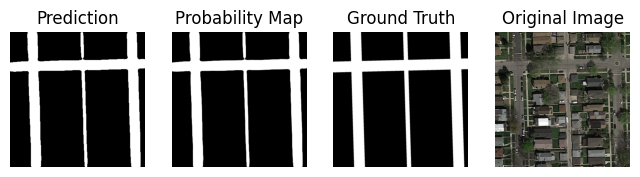

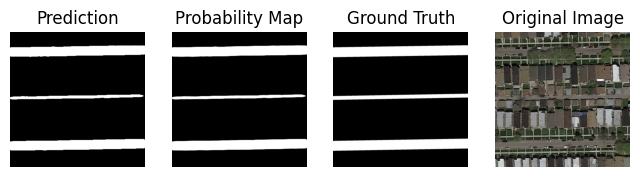

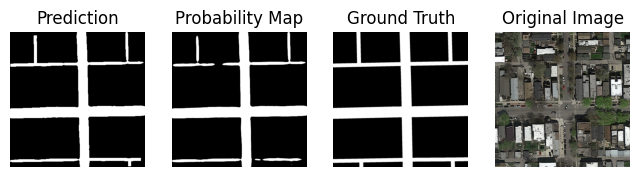

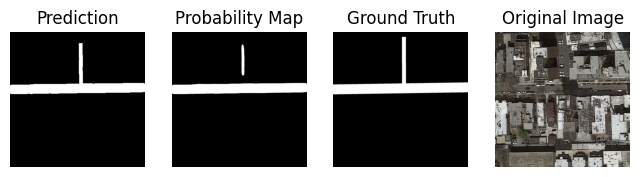

In [10]:
# get plot examples with the trained or loaded UNet model, and train or loaded RC parameters (still on train data)
n_examples = 5

dataset_check = Road_data(imgs, gt_imgs)
dataloader = DataLoader(dataset_check, batch_size=n_examples, shuffle=True)
threshold = 0.5
for batch_idx, (data, target) in enumerate(dataloader):

    gt = target
    pred = model(data)
    gt_np = gt.detach().cpu().numpy()
    pred_np = pred.detach().cpu().numpy()

    for i in range(n_examples):
        fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(8, 8))
        prediction = process_roads(raw_map=pred_np[i], threshold=threshold, outlier_size=best_outlier_size, shape_size=best_shape_size, max_connection_distance=best_mcd, connect=True)[0]
        axes[0].imshow(prediction, cmap='gray')
        axes[0].set_title("Prediction")
        
        axes[1].imshow(pred_np[i], cmap='gray')
        axes[1].set_title("Probability Map")

        axes[2].imshow(gt_np[i], cmap='gray')
        axes[2].set_title("Ground Truth")

        img_np = data[i].permute(1, 2, 0).cpu().numpy() 

        axes[3].imshow(img_np)
        axes[3].set_title("Original Image")

        axes[0].axis("off")
        axes[1].axis("off")
        axes[2].axis("off")
        axes[3].axis("off")

        plt.show()
    
    break

In [11]:
# reset some heavy variables to avoid crashes
dataset = None
dataloader = None
imgs = [load_image(image_dir + files[i]) for i in range(n)]
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
img_np = None
gt = None
gt_dir = None
gt_np = None
pred = None
pred_np = None

### <b> Loading of test images and creation of prediction </b>

In [ ]:
test_dir = "data/test_set_images/"

def natural_sort_key(s):
    # Extract numbers from the string for sorting
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

test_folders = sorted(
    [folder for folder in os.listdir(test_dir) if os.path.isdir(os.path.join(test_dir, folder))],
    key=natural_sort_key
)

n_test = len(test_folders)
print("Loading " + str(n_test) + " images")

test_imgs = []
for folder in test_folders:
    folder_path = os.path.join(test_dir, folder)
    
    image_files = sorted(
        [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))],
        key=natural_sort_key
    )
    
    if image_files:
        image_path = os.path.join(folder_path, image_files[0])
        test_imgs.append(load_image(image_path))

Loading 50 images


c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:216: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  filled_map = closing(cleaned_mask, square(shape_size))
c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:36: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated_skeleton = binary_dilation(skeleton, footprint=square(width))
c:\Master\NSSP\ML\ml-project-2-notaname_p2\road_correction.py:142: FutureWarning: `square` is deprecated since version 0.25 and will be removed in version 0.27. Use `skimage.morphology.footprint_rectangle` instead.
  dilated_region = binary_dilation(current_connection, footprint=square(road_width))


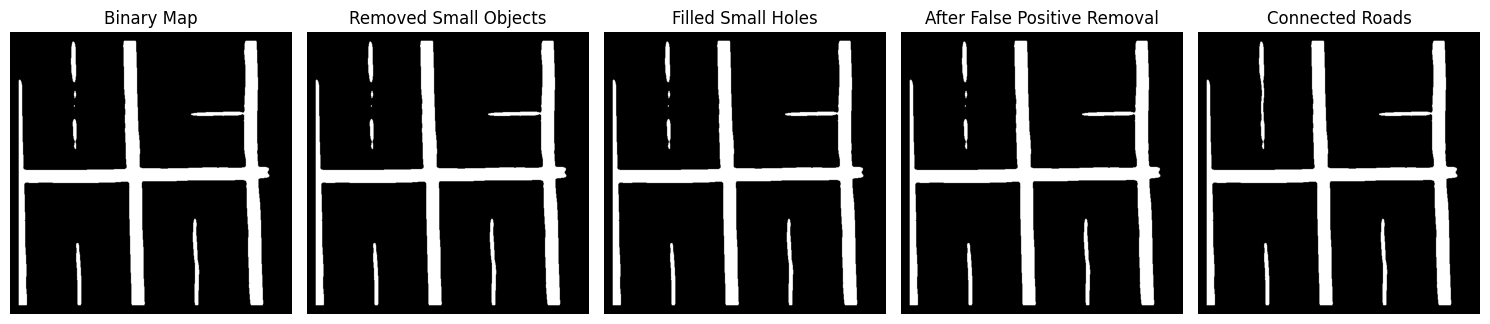

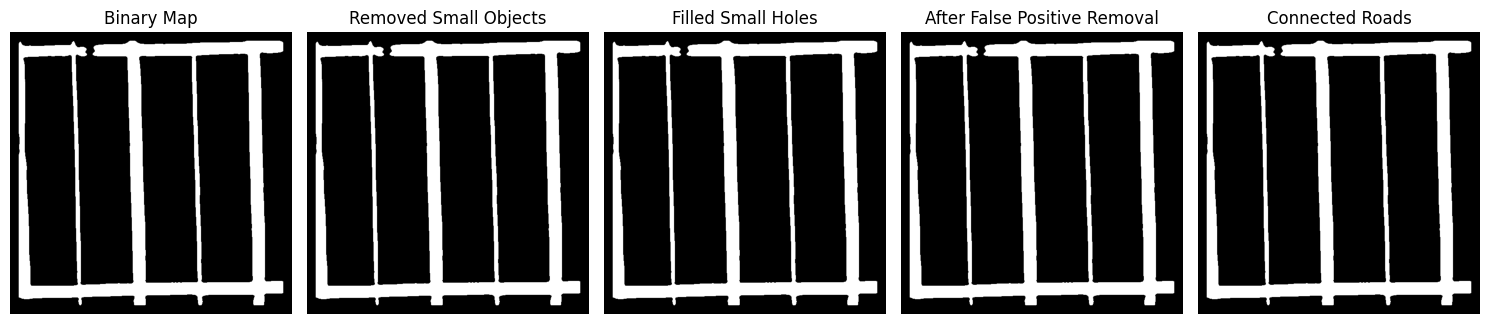

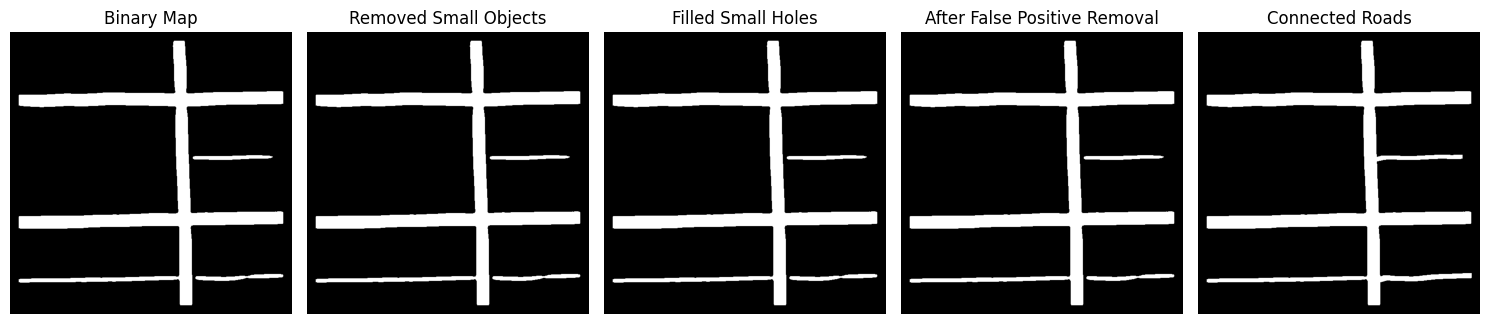

In [17]:
test_imgs_np = np.array(test_imgs)
display = np.zeros(len(test_imgs_np))
display[20] = 1
display[30] = 1
display[40] = 1
with torch.no_grad():
    images_test= torch.from_numpy(test_imgs_np).permute(0, 3, 1, 2)
    pred= model(images_test)
    pred_np = pred.detach().cpu().numpy()
    prediction = [process_roads(raw_map=p, threshold=best_threshold, outlier_size=1, shape_size=best_shape_size, max_connection_distance=best_mcd, display=d, connect=True)[0] for p, d in zip(pred_np,display)]

In [18]:
prediction = np.array(prediction)

In [24]:
def getting_sub(prediction):

    output_dir = 'predictions_opti'
    os.makedirs(output_dir, exist_ok=True)

    # Save each prediction as an image
    pred_filenames = []
    for i in range(prediction.shape[0]):
        pred_mask = (prediction[i] > threshold).astype(np.uint8)  # Example thresholding, modify as needed
        pred_image = Image.fromarray(pred_mask * 255)  # Save the mask as a black and white image
        filename = os.path.join(output_dir, f"prediction_opti{i+1:03d}.png")
        pred_image.save(filename)
        pred_filenames.append(filename)

    # Now you can call the masks_to_submission function with the generated file paths
    masks_to_submission(submission_filename, *pred_filenames)
getting_sub(prediction)